In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pickle

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
data=pd.read_csv('preprocessing_1.csv')

In [4]:
data.head()

,Unnamed: 0,label,p_title,sent_length,word_length,Stops_ratio,Num_Punctuation,category_Berita,category_Ekonomi&Bisnis,category_Lain,...,source_fimela.com,source_kapanlagi.com,source_liputan6.com,source_okezone.com,source_posmetro-medan.com,source_republika.co.id,source_sindonews.com,source_tempo.co,source_tribunnews.com,source_wowkeren.com
0,0,non-clickbait,masuk radar pilwalkot medan menantu jokowi ber...,10,5.800000,0.000000,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,non-clickbait,malaysia sudutkan ri isu kabut asap hingga inv...,9,5.111111,0.111111,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,clickbait,viral driver ojol di bekasi antar pesanan maka...,10,5.300000,0.200000,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,non-clickbait,kemensos salurkan rp m bagi korban kerusuhan s...,10,5.100000,0.200000,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,clickbait,terkait mayat bayi mengenaskan di tangerang se...,10,6.400000,0.200000,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
def category(x):
    if x=='clickbait':
        return 1
    else :
        return 0

In [51]:
data.label=data.label.apply(lambda x:category(x))

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Unnamed: 0','label']), data['label'], test_size=1/3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.8, random_state=42)

In [54]:
X_train.sample()

,p_title,sent_length,word_length,Stops_ratio,Num_Punctuation,category_Berita,category_Ekonomi&Bisnis,category_Lain,category_Lifestyle,category_Olahraga,...,source_fimela.com,source_kapanlagi.com,source_liputan6.com,source_okezone.com,source_posmetro-medan.com,source_republika.co.id,source_sindonews.com,source_tempo.co,source_tribunnews.com,source_wowkeren.com
10869,serunya gita gutawa dan vadi akbar konser di k...,12,5.166667,0.166667,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Embedding

In [119]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
# Limit on the number of features to K features.
TOP_K = 20000

# Limit on the length of text sequences. 
# Sequences longer than this will be truncated.
# and less than it will be padded
MAX_SEQUENCE_LENGTH = 20

class CustomTokenizer:
    def __init__(self, train_texts):
        self.train_texts = train_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
        
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, tweets):
        # Vectorize training and validation texts.
        
        tweets = self.tokenizer.texts_to_sequences(tweets)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        tweets = sequence.pad_sequences(tweets, maxlen=self.max_length, truncating='post',padding='post')
        return tweets
    
tokenizer = CustomTokenizer(train_texts = X_train['p_title'])
# fit o the train
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(X_train['p_title'])
tokenized_val=tokenizer.vectorize_input(X_val['p_title'])
tokenized_test = tokenizer.vectorize_input(X_test['p_title'])

In [120]:
import tqdm
glove_file='id_wiki_100.txt'
EMBEDDING_VECTOR_LENGTH = 100
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file, 'r', errors="ignore") as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix
  
embedding_matrix =  construct_embedding_matrix(glove_file, tokenizer.tokenizer.word_index)

100%|████████████████████████████████████████████████████████████████████████| 14510/14510 [00:00<00:00, 290749.29it/s]


# Self Attentive Network + Structured Variable

In [133]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from keras import backend as K

In [139]:
class attention(tf.keras.layers.Layer): 
    def __init__(self):
        super(attention, self).__init__()
        
    def build(self, input_shape):
        self.num_dim_perword = input_shape[-1] ##Last value of inp:256
        self.W1 = self.add_weight(shape=(self.num_dim_perword,self.num_dim_perword),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        self.W2 = self.add_weight(shape=(self.num_dim_perword,1),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        super(attention, self).build(input_shape)
        
    def call(self, x):
        e = K.dot(K.tanh(K.dot(x,self.W1)),self.W2)
        a = K.softmax(e,axis=-1)
        output = x*a
        return K.sum(output, axis=1)

In [140]:
inputs_word = tf.keras.Input(shape=(20,))
word = tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    100,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False)(inputs_word)
word=tf.keras.layers.Dropout(0.3)(word)
word=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3,return_sequences=True),merge_mode='concat')(word)
word=attention()(word)
word = tf.keras.Model(inputs=inputs_word, outputs=word)
inputs_other= tf.keras.Input(shape=(25,))
model=tf.keras.layers.concatenate([word.output, inputs_other])
model=tf.keras.layers.Dense(1,activation='sigmoid')(model)
model= tf.keras.Model(inputs=[word.input, inputs_other], outputs=model)
model.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 20, 100)      1451100     input_57[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 20, 100)      0           embedding_36[0][0]               
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 20, 128)      84480       dropout_36[0][0]                 
___________________________________________________________________________________________

In [141]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])

In [142]:
i_train = [tokenized_train,X_train.drop(columns=['p_title']).to_numpy()]
i_val= [tokenized_val,X_val.drop(columns=['p_title']).to_numpy()]
i_test= [tokenized_test,X_test.drop(columns=['p_title']).to_numpy()]

In [143]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
histori = model.fit(x=i_train,y=y_train,validation_data=(i_val,y_val),epochs=20, batch_size=64, callbacks=[callback],verbose=2)

Epoch 1/20
157/157 - 18s - loss: 0.5565 - accuracy: 0.7372 - val_loss: 0.4864 - val_accuracy: 0.7720
Epoch 2/20
157/157 - 10s - loss: 0.4517 - accuracy: 0.7858 - val_loss: 0.4320 - val_accuracy: 0.7870
Epoch 3/20
157/157 - 11s - loss: 0.4294 - accuracy: 0.8011 - val_loss: 0.4061 - val_accuracy: 0.8110
Epoch 4/20
157/157 - 11s - loss: 0.4193 - accuracy: 0.8046 - val_loss: 0.4072 - val_accuracy: 0.8040
Epoch 5/20
157/157 - 11s - loss: 0.4111 - accuracy: 0.8101 - val_loss: 0.4175 - val_accuracy: 0.8060
Epoch 6/20
157/157 - 11s - loss: 0.4070 - accuracy: 0.8164 - val_loss: 0.3954 - val_accuracy: 0.8170
Epoch 7/20
157/157 - 11s - loss: 0.4027 - accuracy: 0.8163 - val_loss: 0.3886 - val_accuracy: 0.8080
Epoch 8/20
157/157 - 11s - loss: 0.4053 - accuracy: 0.8133 - val_loss: 0.3918 - val_accuracy: 0.8230
Epoch 9/20
157/157 - 10s - loss: 0.3982 - accuracy: 0.8172 - val_loss: 0.3891 - val_accuracy: 0.8270
Epoch 10/20
157/157 - 10s - loss: 0.3988 - accuracy: 0.8130 - val_loss: 0.3883 - val_accura

In [129]:
import pickle
with open('/SABiLSTMSBFixedHistoryDict', 'wb') as file_pi:
    pickle.dump(histori.history, file_pi)

In [130]:
model.save('SABiLSTMSBFixed')

INFO:tensorflow:Assets written to: SABiLSTMSBFixed\assets


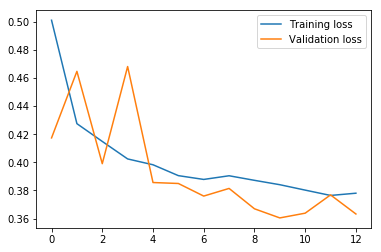

In [131]:
plt.plot(histori.history['loss'],label='Training loss')
plt.plot(histori.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

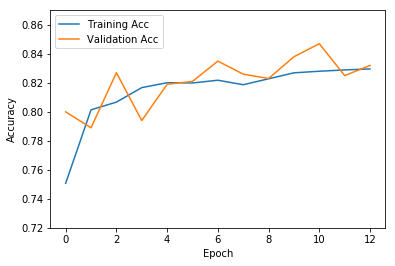

In [132]:
plt.plot(histori.history['accuracy'],label='Training Acc')
plt.plot(histori.history['val_accuracy'],label='Validation Acc')
plt.ylim(0.72,0.87)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [133]:
a_mean,a_std=np.mean(histori.history['accuracy']),np.std(histori.history['accuracy'])
l_mean,l_std=np.mean(histori.history['loss']),np.std(histori.history['loss'])
av_mean,av_std=np.mean(histori.history['val_accuracy']),np.std(histori.history['val_accuracy'])
lv_mean,lv_std=np.mean(histori.history['val_loss']),np.std(histori.history['val_loss'])
print('RNN (SA-BiLSTM + Structured Data)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (SA-BiLSTM + Structured Data)
Training
Accuracy : 0.815 (+-0.020) Loss : 0.401 (+-0.032)
Validation
Accuracy : 0.821 (+-0.017) Loss : 0.393 (+-0.035)


In [98]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_test)])

In [135]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_test)])
test_loss,test_accuracy=model.evaluate(i_test,y_test)

125/125 [==============================] - ETA: 3s - loss: 0.1995 - accuracy: 0.93 - ETA: 1s - loss: 0.3911 - accuracy: 0.82 - ETA: 1s - loss: 0.4218 - accuracy: 0.80 - ETA: 1s - loss: 0.4030 - accuracy: 0.83 - ETA: 1s - loss: 0.3983 - accuracy: 0.83 - ETA: 1s - loss: 0.3859 - accuracy: 0.83 - ETA: 1s - loss: 0.3814 - accuracy: 0.84 - ETA: 1s - loss: 0.3894 - accuracy: 0.84 - ETA: 1s - loss: 0.3804 - accuracy: 0.84 - ETA: 1s - loss: 0.3817 - accuracy: 0.84 - ETA: 1s - loss: 0.3856 - accuracy: 0.84 - ETA: 1s - loss: 0.3947 - accuracy: 0.84 - ETA: 1s - loss: 0.3972 - accuracy: 0.83 - ETA: 1s - loss: 0.3942 - accuracy: 0.83 - ETA: 1s - loss: 0.4022 - accuracy: 0.83 - ETA: 1s - loss: 0.3945 - accuracy: 0.83 - ETA: 1s - loss: 0.3842 - accuracy: 0.84 - ETA: 1s - loss: 0.3837 - accuracy: 0.84 - ETA: 1s - loss: 0.3912 - accuracy: 0.83 - ETA: 1s - loss: 0.3883 - accuracy: 0.84 - ETA: 0s - loss: 0.3930 - accuracy: 0.83 - ETA: 0s - loss: 0.3879 - accuracy: 0.83 - ETA: 0s - loss: 0.3850 - accuracy

In [136]:
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test Loss : 0.389
Test Accuracy : 0.829
F1-Score : 0.780
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2334
           1       0.84      0.73      0.78      1666

    accuracy                           0.83      4000
   macro avg       0.83      0.81      0.82      4000
weighted avg       0.83      0.83      0.83      4000



In [137]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_train)])
test_loss,test_accuracy=model.evaluate(i_train,y_train)

313/313 [==============================] - ETA: 10s - loss: 0.3920 - accuracy: 0.812 - ETA: 5s - loss: 0.2868 - accuracy: 0.859 - ETA: 4s - loss: 0.2987 - accuracy: 0.86 - ETA: 4s - loss: 0.3021 - accuracy: 0.85 - ETA: 4s - loss: 0.3135 - accuracy: 0.85 - ETA: 4s - loss: 0.3156 - accuracy: 0.85 - ETA: 4s - loss: 0.3288 - accuracy: 0.83 - ETA: 5s - loss: 0.3149 - accuracy: 0.84 - ETA: 4s - loss: 0.3076 - accuracy: 0.85 - ETA: 4s - loss: 0.3114 - accuracy: 0.85 - ETA: 4s - loss: 0.3213 - accuracy: 0.84 - ETA: 4s - loss: 0.3138 - accuracy: 0.85 - ETA: 4s - loss: 0.3198 - accuracy: 0.84 - ETA: 4s - loss: 0.3155 - accuracy: 0.85 - ETA: 4s - loss: 0.3146 - accuracy: 0.85 - ETA: 4s - loss: 0.3147 - accuracy: 0.85 - ETA: 4s - loss: 0.3113 - accuracy: 0.85 - ETA: 4s - loss: 0.3130 - accuracy: 0.85 - ETA: 4s - loss: 0.3125 - accuracy: 0.85 - ETA: 4s - loss: 0.3115 - accuracy: 0.85 - ETA: 4s - loss: 0.3097 - accuracy: 0.86 - ETA: 4s - loss: 0.3091 - accuracy: 0.85 - ETA: 4s - loss: 0.3121 - accur

In [138]:
print('Train Loss : %0.3f'%test_loss)
print('Train Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

Train Loss : 0.321
Train Accuracy : 0.857
F1-Score : 0.816
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      5789
           1       0.89      0.75      0.82      4211

    accuracy                           0.86     10000
   macro avg       0.86      0.84      0.85     10000
weighted avg       0.86      0.86      0.86     10000



In [139]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_val)])
test_loss,test_accuracy=model.evaluate(i_val,y_val)

32/32 [==============================] - ETA: 1s - loss: 0.3125 - accuracy: 0.84 - ETA: 0s - loss: 0.3333 - accuracy: 0.85 - ETA: 0s - loss: 0.4121 - accuracy: 0.81 - ETA: 0s - loss: 0.3492 - accuracy: 0.84 - ETA: 0s - loss: 0.3529 - accuracy: 0.83 - ETA: 0s - loss: 0.3688 - accuracy: 0.82 - ETA: 0s - loss: 0.3768 - accuracy: 0.82 - ETA: 0s - loss: 0.3729 - accuracy: 0.82 - ETA: 0s - loss: 0.3550 - accuracy: 0.83 - ETA: 0s - loss: 0.3603 - accuracy: 0.83 - 1s 18ms/step - loss: 0.3633 - accuracy: 0.8320


In [140]:
print('validation Loss : %0.3f'%test_loss)
print('validation Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

validation Loss : 0.363
validation Accuracy : 0.832
F1-Score : 0.781
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       591
           1       0.84      0.73      0.78       409

    accuracy                           0.83      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.83      0.83      1000



# Self Attentive Network

In [144]:
class attention(tf.keras.layers.Layer): 
    def __init__(self):
        super(attention, self).__init__()
        
    def build(self, input_shape):
        self.num_dim_perword = input_shape[-1] ##Last value of inp:256
        self.W1 = self.add_weight(shape=(self.num_dim_perword,self.num_dim_perword),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        self.W2 = self.add_weight(shape=(self.num_dim_perword,1),initializer=tf.keras.initializers.GlorotNormal(),trainable=True)
        super(attention, self).build(input_shape)
        
    def call(self, x):
        e = K.dot(K.tanh(K.dot(x,self.W1)),self.W2)
        a = K.softmax(e,axis=-1)
        output = x*a
        return K.sum(output, axis=1)

In [145]:
state_size = 64
dropout= 0.3
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
mods1=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    100,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, dropout=dropout, recurrent_dropout=0.3,return_sequences=True)),
    attention(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
mods1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
mods1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 20, 100)           1451100   
_________________________________________________________________
dropout_37 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 20, 128)           84480     
_________________________________________________________________
attention_35 (attention)     (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 1,552,221
Trainable params: 101,121
Non-trainable params: 1,451,100
_________________________________________________________________


In [104]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
historie = mods1.fit(tokenized_train,y_train,validation_data=(tokenized_val,y_val),epochs=11, batch_size=64, callbacks=[callback],verbose=2)

Epoch 1/11
157/157 - 18s - loss: 0.5689 - accuracy: 0.7107 - val_loss: 0.5027 - val_accuracy: 0.7530
Epoch 2/11
157/157 - 10s - loss: 0.5224 - accuracy: 0.7475 - val_loss: 0.5001 - val_accuracy: 0.7680
Epoch 3/11
157/157 - 11s - loss: 0.5063 - accuracy: 0.7597 - val_loss: 0.5278 - val_accuracy: 0.7730
Epoch 4/11
157/157 - 10s - loss: 0.4914 - accuracy: 0.7687 - val_loss: 0.4920 - val_accuracy: 0.7800
Epoch 5/11
157/157 - 11s - loss: 0.4774 - accuracy: 0.7759 - val_loss: 0.4717 - val_accuracy: 0.7870
Epoch 6/11
157/157 - 10s - loss: 0.4648 - accuracy: 0.7819 - val_loss: 0.4698 - val_accuracy: 0.7970
Epoch 7/11
157/157 - 11s - loss: 0.4650 - accuracy: 0.7827 - val_loss: 0.4698 - val_accuracy: 0.7970
Epoch 8/11
157/157 - 12s - loss: 0.4554 - accuracy: 0.7891 - val_loss: 0.4489 - val_accuracy: 0.7920
Epoch 9/11
157/157 - 12s - loss: 0.4436 - accuracy: 0.7992 - val_loss: 0.4586 - val_accuracy: 0.7970
Epoch 10/11
157/157 - 13s - loss: 0.4397 - accuracy: 0.7995 - val_loss: 0.4553 - val_accura

In [107]:
with open('/SABiLSTMFixedHistoryDict', 'wb') as file_pi:
    pickle.dump(historie.history, file_pi)
mods1.save('SABiLSTMFixed')

INFO:tensorflow:Assets written to: SABiLSTMFixed\assets


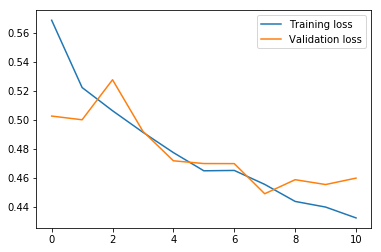

In [108]:
plt.plot(historie.history['loss'],label='Training loss')
plt.plot(historie.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

In [109]:
a_mean,a_std=np.mean(historie.history['accuracy']),np.std(historie.history['accuracy'])
l_mean,l_std=np.mean(historie.history['loss']),np.std(historie.history['loss'])
av_mean,av_std=np.mean(historie.history['val_accuracy']),np.std(historie.history['val_accuracy'])
lv_mean,lv_std=np.mean(historie.history['val_loss']),np.std(historie.history['val_loss'])
print('RNN (SA-BiLSTM)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (SA-BiLSTM)
Training
Accuracy : 0.774 (+-0.026) Loss : 0.479 (+-0.039)
Validation
Accuracy : 0.785 (+-0.014) Loss : 0.478 (+-0.023)


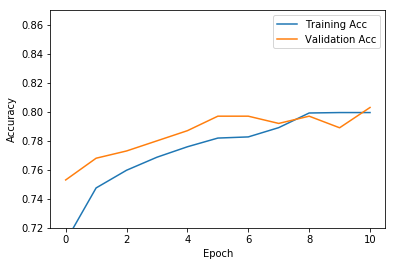

In [110]:
plt.plot(historie.history['accuracy'],label='Training Acc')
plt.plot(historie.history['val_accuracy'],label='Validation Acc')
plt.ylim(0.72,0.87)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [111]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_test)])

In [112]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_test)])
test_loss,test_accuracy=mods1.evaluate(tokenized_test,y_test)

125/125 [==============================] - ETA: 6:55 - loss: 0.3784 - accuracy: 0.84 - ETA: 1s - loss: 0.5044 - accuracy: 0.7812 - ETA: 1s - loss: 0.5169 - accuracy: 0.79 - ETA: 1s - loss: 0.4689 - accuracy: 0.79 - ETA: 1s - loss: 0.4848 - accuracy: 0.78 - ETA: 1s - loss: 0.4899 - accuracy: 0.78 - ETA: 1s - loss: 0.4832 - accuracy: 0.79 - ETA: 1s - loss: 0.4762 - accuracy: 0.79 - ETA: 1s - loss: 0.4807 - accuracy: 0.79 - ETA: 1s - loss: 0.4720 - accuracy: 0.79 - ETA: 1s - loss: 0.4616 - accuracy: 0.79 - ETA: 1s - loss: 0.4667 - accuracy: 0.79 - ETA: 1s - loss: 0.4670 - accuracy: 0.79 - ETA: 1s - loss: 0.4540 - accuracy: 0.79 - ETA: 0s - loss: 0.4555 - accuracy: 0.80 - ETA: 0s - loss: 0.4706 - accuracy: 0.79 - ETA: 0s - loss: 0.4786 - accuracy: 0.78 - ETA: 0s - loss: 0.4805 - accuracy: 0.78 - ETA: 0s - loss: 0.4754 - accuracy: 0.79 - ETA: 0s - loss: 0.4811 - accuracy: 0.78 - ETA: 0s - loss: 0.4873 - accuracy: 0.78 - ETA: 0s - loss: 0.4991 - accuracy: 0.78 - ETA: 0s - loss: 0.5011 - accu

In [113]:
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test Loss : 0.490
Test Accuracy : 0.785
F1-Score : 0.730
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2334
           1       0.76      0.70      0.73      1666

    accuracy                           0.79      4000
   macro avg       0.78      0.77      0.78      4000
weighted avg       0.78      0.79      0.78      4000



In [114]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_train)])
test_loss,test_accuracy=mods1.evaluate(tokenized_train,y_train)

313/313 [==============================] - ETA: 8s - loss: 0.3832 - accuracy: 0.78 - ETA: 3s - loss: 0.4005 - accuracy: 0.82 - ETA: 3s - loss: 0.3736 - accuracy: 0.83 - ETA: 3s - loss: 0.3907 - accuracy: 0.81 - ETA: 3s - loss: 0.3920 - accuracy: 0.81 - ETA: 3s - loss: 0.3797 - accuracy: 0.82 - ETA: 3s - loss: 0.3739 - accuracy: 0.82 - ETA: 3s - loss: 0.3808 - accuracy: 0.82 - ETA: 3s - loss: 0.3826 - accuracy: 0.82 - ETA: 3s - loss: 0.3739 - accuracy: 0.82 - ETA: 3s - loss: 0.3699 - accuracy: 0.83 - ETA: 3s - loss: 0.3658 - accuracy: 0.83 - ETA: 3s - loss: 0.3653 - accuracy: 0.83 - ETA: 3s - loss: 0.3624 - accuracy: 0.83 - ETA: 2s - loss: 0.3603 - accuracy: 0.83 - ETA: 2s - loss: 0.3553 - accuracy: 0.84 - ETA: 2s - loss: 0.3542 - accuracy: 0.84 - ETA: 2s - loss: 0.3547 - accuracy: 0.84 - ETA: 2s - loss: 0.3523 - accuracy: 0.84 - ETA: 2s - loss: 0.3571 - accuracy: 0.84 - ETA: 2s - loss: 0.3575 - accuracy: 0.84 - ETA: 2s - loss: 0.3578 - accuracy: 0.84 - ETA: 2s - loss: 0.3610 - accuracy

In [115]:
print('Train Loss : %0.3f'%test_loss)
print('Train Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

Train Loss : 0.353
Train Accuracy : 0.848
F1-Score : 0.815
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5789
           1       0.84      0.80      0.82      4211

    accuracy                           0.85     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.85      0.85     10000



In [116]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_val)])
test_loss,test_accuracy=mods1.evaluate(tokenized_val,y_val)

32/32 [==============================] - ETA: 1s - loss: 0.4234 - accuracy: 0.81 - ETA: 0s - loss: 0.5071 - accuracy: 0.77 - ETA: 0s - loss: 0.4344 - accuracy: 0.81 - ETA: 0s - loss: 0.4629 - accuracy: 0.79 - ETA: 0s - loss: 0.4919 - accuracy: 0.78 - ETA: 0s - loss: 0.4701 - accuracy: 0.79 - ETA: 0s - loss: 0.4628 - accuracy: 0.80 - 0s 12ms/step - loss: 0.4597 - accuracy: 0.8030


In [117]:
print('validation Loss : %0.3f'%test_loss)
print('validation Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

validation Loss : 0.460
validation Accuracy : 0.803
F1-Score : 0.752
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       591
           1       0.77      0.73      0.75       409

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



# BiLSTM

In [45]:
state_size = 64
dropout= 0.3
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
mods=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    100,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, dropout=dropout, recurrent_dropout=0.3)),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
mods.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
mods.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 100)           1451100   
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,535,709
Trainable params: 84,609
Non-trainable params: 1,451,100
_________________________________________________________________


In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
histories = mods.fit(tokenized_train,y_train,validation_data=(tokenized_val,y_val),
                    epochs=9, batch_size=64, callbacks=[callback],
                    verbose=2)

Epoch 1/20
157/157 - 17s - loss: 0.5784 - accuracy: 0.6976 - val_loss: 0.5023 - val_accuracy: 0.7470
Epoch 2/20
157/157 - 10s - loss: 0.5240 - accuracy: 0.7437 - val_loss: 0.4884 - val_accuracy: 0.7710
Epoch 3/20
157/157 - 9s - loss: 0.5054 - accuracy: 0.7567 - val_loss: 0.5026 - val_accuracy: 0.7730
Epoch 4/20
157/157 - 8s - loss: 0.4971 - accuracy: 0.7644 - val_loss: 0.4838 - val_accuracy: 0.7760
Epoch 5/20
157/157 - 9s - loss: 0.4815 - accuracy: 0.7723 - val_loss: 0.4652 - val_accuracy: 0.7760
Epoch 6/20
157/157 - 9s - loss: 0.4705 - accuracy: 0.7788 - val_loss: 0.4869 - val_accuracy: 0.7830
Epoch 7/20
157/157 - 9s - loss: 0.4628 - accuracy: 0.7825 - val_loss: 0.4628 - val_accuracy: 0.7840
Epoch 8/20
157/157 - 8s - loss: 0.4556 - accuracy: 0.7899 - val_loss: 0.4661 - val_accuracy: 0.7930
Epoch 9/20
157/157 - 9s - loss: 0.4484 - accuracy: 0.7913 - val_loss: 0.4531 - val_accuracy: 0.7960
Epoch 10/20
157/157 - 11s - loss: 0.4397 - accuracy: 0.7949 - val_loss: 0.4548 - val_accuracy: 0.7

In [118]:
with open('/BiLSTMFixedHistoryDict', 'wb') as file_pi:
    pickle.dump(histories.history, file_pi)
mods.save('BiLSTMFixed')

INFO:tensorflow:Assets written to: BiLSTMFixed\assets


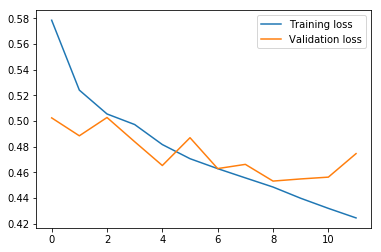

In [119]:
plt.plot(histories.history['loss'],label='Training loss')
plt.plot(histories.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

In [120]:
a_mean,a_std=np.mean(histories.history['accuracy']),np.std(histories.history['accuracy'])
l_mean,l_std=np.mean(histories.history['loss']),np.std(histories.history['loss'])
av_mean,av_std=np.mean(histories.history['val_accuracy']),np.std(histories.history['val_accuracy'])
lv_mean,lv_std=np.mean(histories.history['val_loss']),np.std(histories.history['val_loss'])
print('RNN (BiLSTM)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (BiLSTM)
Training
Accuracy : 0.773 (+-0.029) Loss : 0.477 (+-0.042)
Validation
Accuracy : 0.781 (+-0.013) Loss : 0.475 (+-0.017)


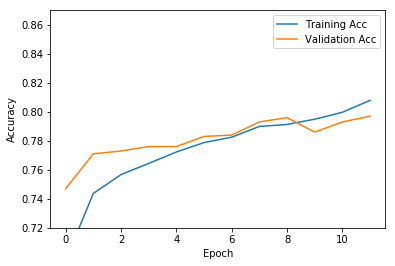

In [121]:
plt.plot(histories.history['accuracy'],label='Training Acc')
plt.plot(histories.history['val_accuracy'],label='Validation Acc')
plt.ylim(0.72,0.87)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [122]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_test)])

In [123]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_test)])
test_loss,test_accuracy=mods.evaluate(tokenized_test,y_test)

125/125 [==============================] - ETA: 3s - loss: 0.3908 - accuracy: 0.84 - ETA: 1s - loss: 0.5523 - accuracy: 0.76 - ETA: 1s - loss: 0.5363 - accuracy: 0.76 - ETA: 1s - loss: 0.4804 - accuracy: 0.78 - ETA: 1s - loss: 0.4896 - accuracy: 0.78 - ETA: 1s - loss: 0.4603 - accuracy: 0.80 - ETA: 1s - loss: 0.4674 - accuracy: 0.80 - ETA: 1s - loss: 0.4743 - accuracy: 0.79 - ETA: 0s - loss: 0.4749 - accuracy: 0.79 - ETA: 0s - loss: 0.4832 - accuracy: 0.78 - ETA: 0s - loss: 0.4889 - accuracy: 0.78 - ETA: 0s - loss: 0.4745 - accuracy: 0.79 - ETA: 0s - loss: 0.4750 - accuracy: 0.79 - ETA: 0s - loss: 0.4883 - accuracy: 0.78 - ETA: 0s - loss: 0.4895 - accuracy: 0.78 - ETA: 0s - loss: 0.4801 - accuracy: 0.79 - ETA: 0s - loss: 0.4911 - accuracy: 0.78 - ETA: 0s - loss: 0.4980 - accuracy: 0.78 - ETA: 0s - loss: 0.5108 - accuracy: 0.77 - ETA: 0s - loss: 0.5095 - accuracy: 0.77 - ETA: 0s - loss: 0.5067 - accuracy: 0.77 - ETA: 0s - loss: 0.5027 - accuracy: 0.78 - ETA: 0s - loss: 0.5020 - accuracy

In [124]:
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test Loss : 0.503
Test Accuracy : 0.782
F1-Score : 0.717
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      2334
           1       0.78      0.66      0.72      1666

    accuracy                           0.78      4000
   macro avg       0.78      0.77      0.77      4000
weighted avg       0.78      0.78      0.78      4000



In [125]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_val)])
test_loss,test_accuracy=mods.evaluate(tokenized_val,y_val)

32/32 [==============================] - ETA: 1s - loss: 0.4444 - accuracy: 0.81 - ETA: 0s - loss: 0.5548 - accuracy: 0.75 - ETA: 0s - loss: 0.4821 - accuracy: 0.77 - ETA: 0s - loss: 0.5111 - accuracy: 0.77 - ETA: 0s - loss: 0.5231 - accuracy: 0.77 - ETA: 0s - loss: 0.4878 - accuracy: 0.79 - ETA: 0s - loss: 0.4774 - accuracy: 0.79 - 0s 11ms/step - loss: 0.4745 - accuracy: 0.7970


In [126]:
print('Validation Loss : %0.3f'%test_loss)
print('Validation Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

Validation Loss : 0.474
Validation Accuracy : 0.797
F1-Score : 0.730
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       591
           1       0.80      0.67      0.73       409

    accuracy                           0.80      1000
   macro avg       0.80      0.78      0.78      1000
weighted avg       0.80      0.80      0.79      1000



In [127]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_train)])
test_loss,test_accuracy=mods.evaluate(tokenized_train,y_train)

313/313 [==============================] - ETA: 8s - loss: 0.3313 - accuracy: 0.84 - ETA: 3s - loss: 0.4357 - accuracy: 0.80 - ETA: 3s - loss: 0.3588 - accuracy: 0.84 - ETA: 3s - loss: 0.3762 - accuracy: 0.83 - ETA: 3s - loss: 0.3866 - accuracy: 0.81 - ETA: 3s - loss: 0.3663 - accuracy: 0.82 - ETA: 3s - loss: 0.3557 - accuracy: 0.83 - ETA: 3s - loss: 0.3656 - accuracy: 0.83 - ETA: 3s - loss: 0.3611 - accuracy: 0.83 - ETA: 2s - loss: 0.3545 - accuracy: 0.84 - ETA: 2s - loss: 0.3517 - accuracy: 0.84 - ETA: 2s - loss: 0.3522 - accuracy: 0.84 - ETA: 2s - loss: 0.3505 - accuracy: 0.84 - ETA: 2s - loss: 0.3507 - accuracy: 0.84 - ETA: 2s - loss: 0.3428 - accuracy: 0.84 - ETA: 2s - loss: 0.3439 - accuracy: 0.84 - ETA: 2s - loss: 0.3444 - accuracy: 0.84 - ETA: 2s - loss: 0.3460 - accuracy: 0.84 - ETA: 2s - loss: 0.3462 - accuracy: 0.84 - ETA: 2s - loss: 0.3501 - accuracy: 0.84 - ETA: 2s - loss: 0.3506 - accuracy: 0.84 - ETA: 2s - loss: 0.3518 - accuracy: 0.84 - ETA: 2s - loss: 0.3556 - accuracy

In [128]:
print('Training Loss : %0.3f'%test_loss)
print('Training Accuracy : %0.3f'%test_accuracy)
print('F1-Score : %0.3f'%f1_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

Training Loss : 0.350
Training Accuracy : 0.845
F1-Score : 0.805
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      5789
           1       0.85      0.76      0.81      4211

    accuracy                           0.84     10000
   macro avg       0.85      0.83      0.84     10000
weighted avg       0.85      0.84      0.84     10000

